In [134]:
import re, os
import unicodedata
import json

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime
from scipy.stats import f_oneway

import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

---

## Acquisition

Our data was acquired from kaggle.com by dowloading it directly from the [Interview: NPR Media Dialog Transcripts kaggle dataset](https://www.kaggle.com/shuyangli94/interview-npr-media-dialog-transcripts/code) website.

- After downloading the relevant .csv files, our working dataset comes from two different sources (`utterances.csv` and `episodes.csv`) combined into one. 
- Our acquire script also did the following:
 - Combined dataset was put together via inner join.
 - Unnecessary and/or redundant columns were dropped or renamed.  
 - The string columns were all converted to lowercase.
 - Finally, an additional column, is_host, was created to identify whether the speaker for a specific row was an NPR host or not.

In [14]:
# load csv file into a df
df = pd.read_csv('npr_corpus.csv')

In [25]:
joined_df

,episode_id,episode_order,speaker,utterance,program,title,episode_date,is_host
0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,2010-07-12,False
1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,2010-07-12,False
2,57264,11,"neal conan, host","So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,2010-07-12,True
3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,2010-07-12,False
4,57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,2010-07-12,True
...,...,...,...,...,...,...,...,...
3199853,69759,31,ray magliozzi,"Oh, I don't know about that.",all things considered,should you warm up your car before driving to ...,2017-12-29,False
3199854,69759,32,_no_speaker,(LAUGHTER),all things considered,should you warm up your car before driving to ...,2017-12-29,False
3199855,69759,33,"robert siegel, host","Ray Magliozzi, co-host of the longtime NPR pro...",all things considered,should you warm up your car before driving to ...,2017-12-29,True
3199856,69759,34,ray magliozzi,"Nice to talk to you, too, Robert - my pleasure.",all things considered,should you warm up your car before driving to ...,2017-12-29,False


---

## Preparation

The merged dataset from Kaggle went through the following preparation steps:

1. Looked up the top 10 hosts with the most speaking lines.
2. Using a mask with the episode ID from the top 10 hosts with the most speaking lines, a new dataframe was created from the result.
3. Any rows with foreign languages spoken were removed.
4. Any rows with no speaker listed were removed.
5. Duplicate and null values were dropped.
6. `Cleaned` and `lemmatized` column versions were created from the `utterances` column.
7. A column representing the sentiment score for each utterance was added.
8. Any date-like data was transformed into a datetime object.
9. Episodes prior to 2005 were dropped due to low observation count.
10. Renamed a couple columns for purposes of making working with this dataset easier.
11. The `episode_date` column was dropped.
12. The `speaker` column was modified via regular expression to extract the name of the speaker only.
13. Double checked our `is_host` column.


In [15]:
# prepare dataset from script functions
df = wrangle.get_npr_data()

The df has 1889857 rows and 12 columns.


In [16]:
# dataset ready
df.head()

,story_id_num,utterance_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889857 entries, 0 to 3199856
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   story_id_num     int64  
 1   utterance_order  int64  
 2   speaker          object 
 3   utterance        object 
 4   program          object 
 5   title            object 
 6   is_host          bool   
 7   clean            object 
 8   lemmatized       object 
 9   vader            float64
 10  date             object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 160.4+ MB


---

## Exploration

Initial Questions:

- **Which NPR speakers have spoken the most lines spoken?**
    - `Neal Conan` has the most lines spoken in this dataset.
    - `Ira Flatlow` and `Steve Inskeep` come in at second and third place, respectively.

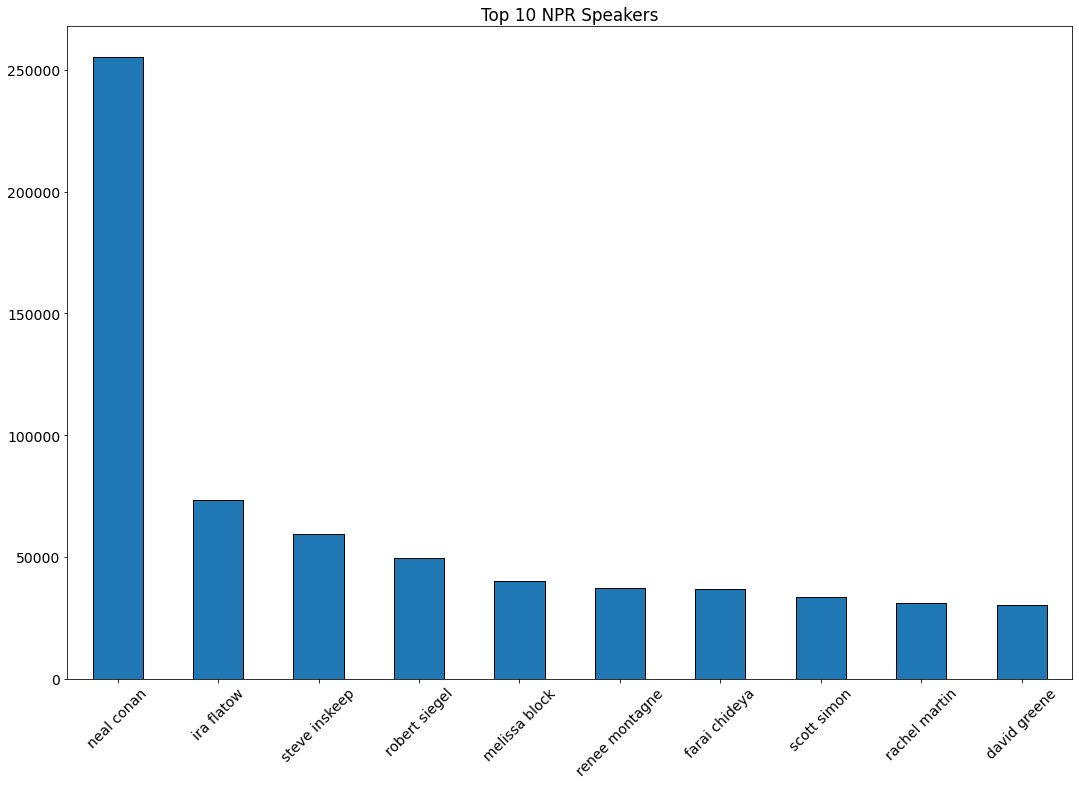

In [81]:
df.speaker[df.is_host == True].value_counts().head(10).plot.bar(title = 'Top 10 NPR Speakers', 
                                                                ec = 'black',
                                                               figsize = (18, 12))
plt.rc('font', size = 14)
plt.xticks(rotation = 45);

- **Who asks the most questions?**
    - As shown below, Neal Conan has asked overr 250,000 questions on air! That's over 3 times the number two host in questions.
    - Conan hosted talk of the nation, a two-hour daily interview program for years.
    - Flatow hosted and still hosts Science Friday, a weekly interview program that started as a spinoff of Talk of the Nation

In [84]:
# create a question mark count column
df['question_mark_count'] = df.utterance.str.count(r"[\?]")

# extract the total number of question marks for every given speaker, display top ten
df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10).T

,81830,29199,98098,91806,46070,89616,23679,94514,88612,15210
speaker,neal conan,ira flatow,steve inskeep,robert siegel,melissa block,renee montagne,farai chideya,scott simon,rachel martin,david greene
count,255146,73209,59566,49750,39984,37241,36719,33394,31292,30419


- **Do NPR hosts ask more questions than guests?**
    - Yes, our visual below provides ample proof that hosts ask far moroe questions than guests.

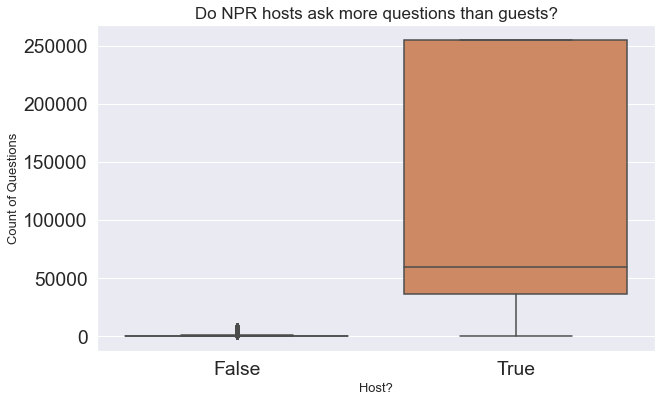

In [125]:
# create a question mark count df from the above code
questions = df[['speaker','question_mark_count']].groupby(['speaker'])['question_mark_count'] \
                             .count() \
                             .reset_index(name = 'count') \
                             .sort_values(['count'], ascending = False)

# merge it with the whole df no speaker for viz purposes below
questions = questions.merge(df, how ='left', on ='speaker').drop(columns = ['story_id_num', 'utterance_order', 'utterance',
       'title','clean', 'lemmatized', 'vader',
       'question_mark_count'])

plt.figure(figsize = (10, 6))
viz = sns.boxplot(data = questions, x = 'is_host', y ='count')
viz.set_xlabel('Host?', fontsize = 13)
viz.set_ylabel('Count of Questions', fontsize = 13)
viz.set_title('Do NPR hosts ask more questions than guests?', fontsize = 17);

- **Is there a difference in the mean sentiment by speaker? Program?**
    - As seen in the visualization below, the average sentiment score is relatively neutral accross all top hosts, although some rate higher:
        - Scott Simon, for instance, who hosts a weekend program
        - Rachel Martin bucks the trends: she co-hosts Morning Edition, a weekday daily with a lower average sentiment score overall
        - Stoic Melissa Block has the lowestvader score, and hosted All Things Considered for years, a daily afternoon news/politics program
    - The mean sentiment value is awfully close for everyone here, so we stats test it with an ANOVA test next...

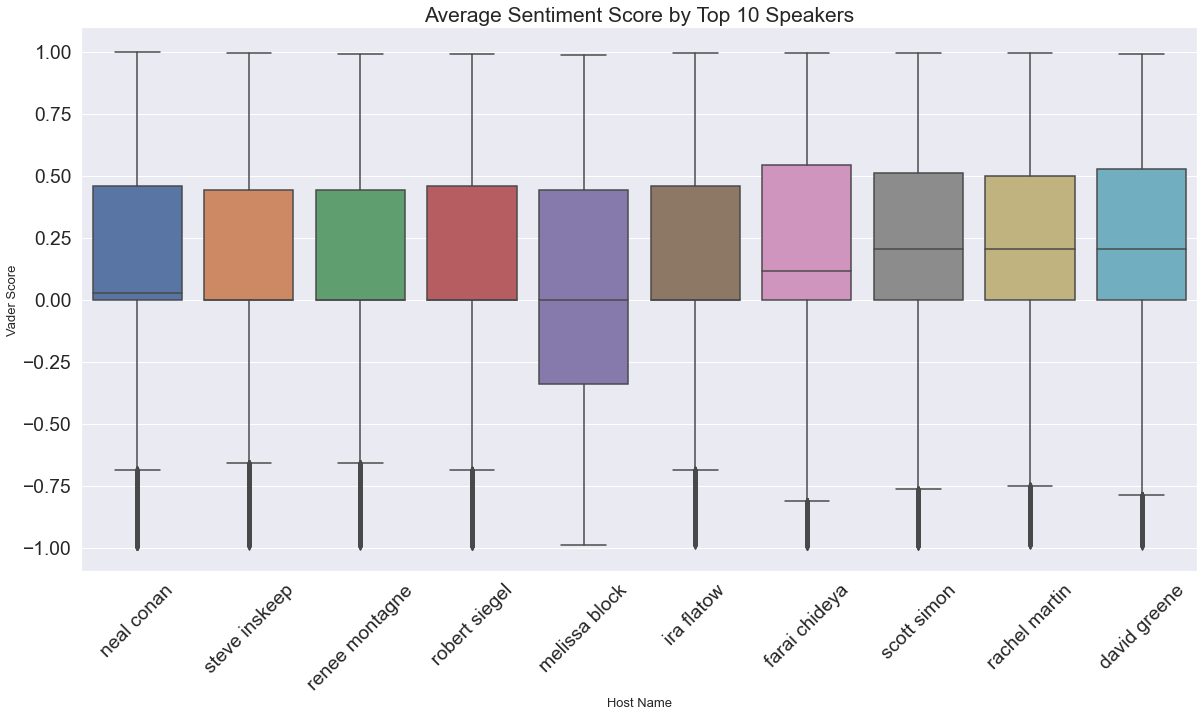

In [168]:
# host df
host_df = df[df.is_host == True]

# top 10 hosts with the most obseravtions
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

# limits the overal df to. only thee hosts_with_the_most
top_hosts_df = df[df.speaker.isin(hosts_with_the_most)]

# boxplots of the sentiment scores of the top hosts
plt.figure(figsize = (20,10))
viz = sns.boxplot(data = top_hosts_df,x = 'speaker', y = 'vader')
viz.set_title('Average Sentiment Score by Top 10 Speakers')
viz.set_xlabel('Host Name', fontsize = 13)
viz.set_ylabel('Vader Score', fontsize = 13)
plt.xticks(rotation = 45);

In [130]:
# create a null and alt hypothesis for stats testing
null_hypothesis = "Average sentiment score is the same across hosts"
alternative_hypothesis = "Average sentiment score is different in at least one host of the group"

alpha = 0.01 # let's be 99% certain the result we see isn't due to chance/randomness

**Set Hypothesis**

$H_{0}$: Average sentiment score is the same across hosts
 
$H_{a}$: Average sentiment score is different in at least one host of the group

In [133]:
# let's isolate the hosts for stats testing
neal_df = df[df.speaker == 'neal conan'].vader
ira_df = df[df.speaker == 'ira flatow'].vader
robert_df = df[df.speaker == 'robert siegel'].vader
steve_df = df[df.speaker == 'steve inskeep'].vader
melissa_df = df[df.speaker == 'melissa block'].vader
farai_df = df[df.speaker == 'farai chideya'].vader
renee_df = df[df.speaker == 'renee montagne'].vader
scott_df = df[df.speaker == 'scott simon'].vader
david_df = df[df.speaker == 'david greene'].vader
rachel_df = df[df.speaker == 'rachel martin'].vader

In [135]:
f, p = f_oneway(neal_df, ira_df, robert_df, steve_df, melissa_df, farai_df, renee_df, scott_df, david_df, rachel_df)
f, p

(614.3140717245919, 0.0)

In [136]:
# if statement to  return the result of the stats testing
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that Average sentiment score is the same across hosts
We move forward with the alternative hypothesis that Average sentiment score is different in at least one host of the group


- **What's the difference in sentiment score between hosts and non-hosts?**
    - NPR hosts tend to keep it neutral in the sentiment department.
    - The average sentiment score for non-hosts is somewhat higher than for the hosts.

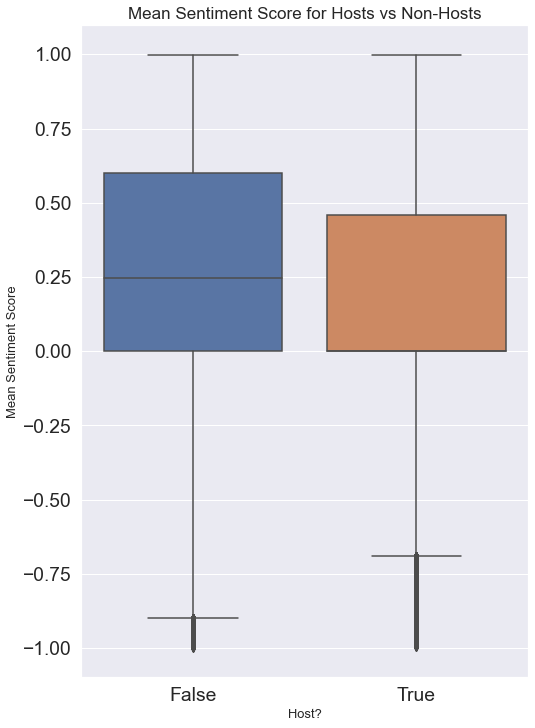

In [170]:
# create a non-host df
non_host_df = df[df.is_host == False]

# plot vader score for hosts versus not
plt.figure
viz = sns.boxplot(data = df, x = 'is_host', y = 'vader')
viz.set_xlabel('Host?', fontsize = 13)
viz.set_ylabel('Mean Sentiment Score', fontsize = 13)
viz.set_title('Mean Sentiment Score for Hosts vs Non-Hosts', fontsize = 17);

In [142]:
# create a null and alt hypothesis for stats testing
null_hypothesis = "Hosts and Non-hosts have the same sentiment score"
alternative_hypothesis = "Hosts and Non-hosts have different sentiment scores"

alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

**Set Hypothesis**

$H_{0}$: Hosts and Non-hosts have the same sentiment score
 
$H_{a}$: Hosts and Non-hosts have different sentiment scores

In [143]:
#stats testing on the same
t, p = stats.ttest_ind(host_df.vader,non_host_df.vader)
t, p

(-46.94868048801413, 0.0)

In [144]:
# if statement to  return the result of the stats testing
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print(f"Evidence does not support the claim that", alternate_hypothesis)

We reject the null hypothesis that Hosts and Non-hosts have the same sentiment score
We move forward with the hypothesis that Hosts and Non-hosts have different sentiment scores


- **How about sentiment score by year? Month? Day?**
    - There weren't enough data points fro 2000 through 2003 so those values were dropped.
    - Visualization by year did not demonstrate a trend.
    - Visualization by month also didn't demonstrate a trend.
    - However, the impression is that sentiment is a little higher on the weekend, dipping Mondays and rising Fridays into the weekend.

In [159]:
# set date to datetime
df['date'] = pd.to_datetime(df.date)

# set date to index
df = df.set_index('date').sort_index()

# resample vader score by year
df.resample('Y').vader.mean()

date
2005-12-31    0.169318
2006-12-31    0.161386
2007-12-31    0.180956
2008-12-31    0.209603
2009-12-31    0.193803
2010-12-31    0.184554
2011-12-31    0.172069
2012-12-31    0.188927
2013-12-31    0.157618
2014-12-31    0.131946
2015-12-31    0.139144
2016-12-31    0.164225
2017-12-31    0.171218
2018-12-31    0.166342
2019-12-31    0.156179
Freq: A-DEC, Name: vader, dtype: float64

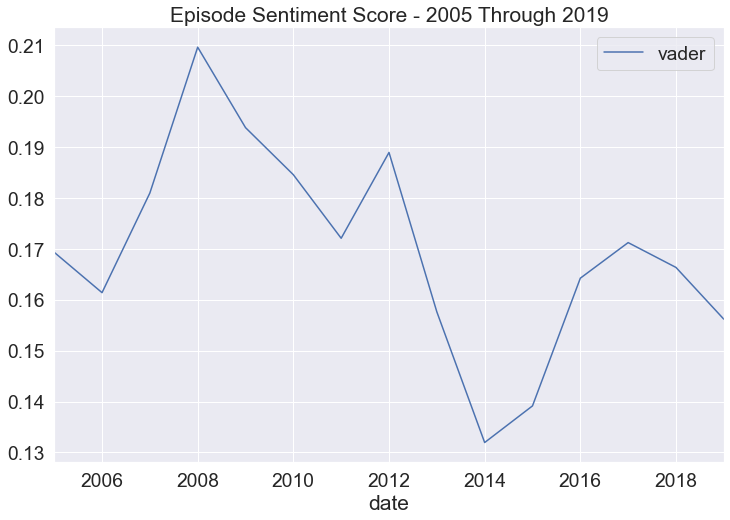

In [162]:
# create yearly vader df
vader_yearly = pd.DataFrame(df.resample('Y').vader.mean())

# and plot
vader_yearly.plot(figsize = (12, 8), title = 'Episode Sentiment Score - 2005 Through 2019');

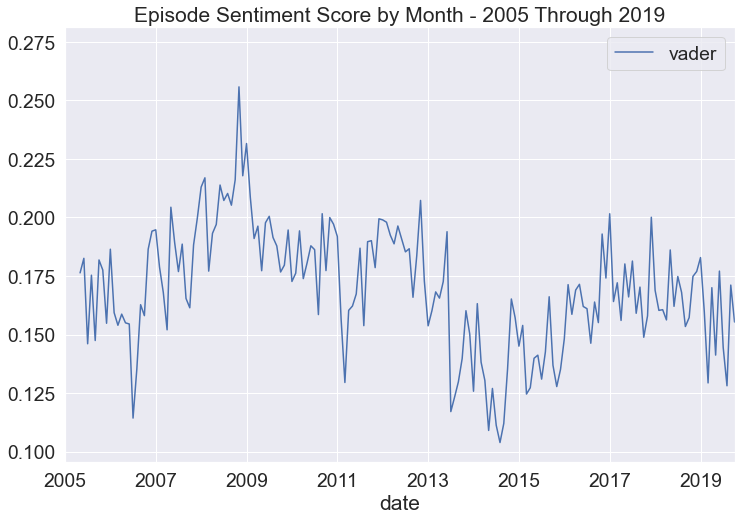

In [164]:
# create monthly vader df
vader_monthly = pd.DataFrame(df.resample('M').vader.mean())

# and plot
vader_monthly.plot(figsize = (12, 8), title = 'Episode Sentiment Score by Month - 2005 Through 2019');

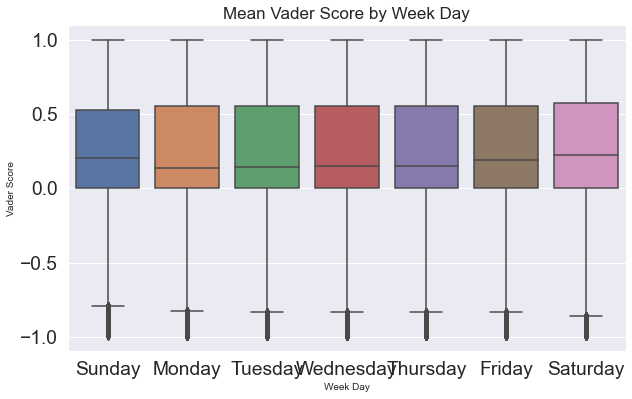

In [173]:
# sentiment score by  day of week
df.groupby(df.index.day_name()).vader.mean()

# sentiment by day, 0 is monday, 6 is sunday

# plot and order the avg sentiment score by day of week
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plt.figure(figsize = (10,6))
viz = sns.boxplot(data = df, x = df.index.day_name(), y = 'vader', order = order)
viz.set_xlabel('Week Day', fontsize = 10)
viz.set_ylabel('Vader Score', fontsize = 10)
viz.set_title('Mean Vader Score by Week Day', fontsize = 17);

- **How Does Sentiment Score Differ by Program?**
    - dfd